# Project 1 Neuronal networks

## 1.- MNIST and FMINST datasets

In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'  #To get figures with high quality!

import numpy as np
import torch
from torch import nn
from torch import optim
import matplotlib.pyplot as plt

In [2]:
# !pip install wandb
import wandb # Weight & Biases library to monitor training and compare models
wandb.login() # API key: 569de9861dbe18fe8888f13ca66e39d2b12934ff

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: alejogonzalez9 (zurdito). Use `wandb login --relogin` to force relogin


True

To obtain the MNIST dataset:

In [3]:
### Run this cell

from torchvision import datasets, transforms

# Define a transform to normalize the data
transform = transforms.Compose([transforms.ToTensor(),
                              transforms.Normalize((0.5,), (0.5,)),
                              ])

# Download and load the training  data
trainsetMNIST = datasets.MNIST('~/.pytorch/MNIST_data/', download=True, train=True, transform=transform)
train_MNIST = torch.utils.data.DataLoader(trainsetMNIST, batch_size=64, shuffle=True)

# Download and load the test data
testsetMNIST = datasets.MNIST('~/.pytorch/MNIST_data/', download=True, train=False, transform=transform)
test_MNIST = torch.utils.data.DataLoader(testsetMNIST, batch_size=64, shuffle=True)

To obtain the FMINST dataset:

In [4]:

# Download and load the training data
trainsetFMNIST = datasets.FashionMNIST('~/.pytorch/F_MNIST_data/', download=True, train=True, transform=transform)
train_FMNIST = torch.utils.data.DataLoader(trainsetFMNIST, batch_size=64, shuffle=True)

# Download and load the test data
testsetFMNIST = datasets.FashionMNIST('~/.pytorch/F_MNIST_data/', download=True, train=False, transform=transform)
test_FMNIST = torch.utils.data.DataLoader(testsetFMNIST, batch_size=64, shuffle=True)

In [5]:
dataiter = iter(train_MNIST)   #To iterate through the dataset

images, labels = next(dataiter)
print(type(images))
print(images.shape)
print(labels.shape)
print(torch.min(images), torch.max(images))

<class 'torch.Tensor'>
torch.Size([64, 1, 28, 28])
torch.Size([64])
tensor(-1.) tensor(1.)


In [6]:
dataiter = iter(train_FMNIST)   #To iterate through the dataset

images, labels = next(dataiter)
print(type(images))
print(images.shape)
print(labels.shape)
print(torch.min(images), torch.max(images))

<class 'torch.Tensor'>
torch.Size([64, 1, 28, 28])
torch.Size([64])
tensor(-1.) tensor(1.)


We can see that our images are of size 28 x 28 = 784, so the input layer is of size 784. It is important to see that the range of the values are -1,1 so for the output layer we will use the tanh.

We also need to split the training data into training and validation sets.

In [7]:
import copy


valid_MNIST = copy.deepcopy(train_MNIST)  # Creates a copy of the object

#We take the first 45k images for training
train_MNIST.dataset.data = train_MNIST.dataset.data[:45000,:,:]

#And the rest for validation
valid_MNIST.dataset.data = valid_MNIST.dataset.data[45000:,:,:]




In [8]:
import copy

valid_FMNIST = copy.deepcopy(train_FMNIST)  # Creates a copy of the object

#We take the first 45k images for training
train_FMNIST.dataset.data = train_FMNIST.dataset.data[:45000,:,:]

#And the rest for validation
valid_FMNIST.dataset.data = valid_FMNIST.dataset.data[45000:,:,:]

Select Data Set To Be Trained: 

In [9]:
INDEX = 1 # INDEX = 0 for MNIST and 1 for FMNIST!

train_set = [train_MNIST, train_FMNIST]
valid_set = [valid_MNIST, valid_FMNIST]

print( train_set[0].dataset.data.shape, train_set[1].dataset.data.shape)
print( valid_set[0].dataset.data.shape, valid_set[1].dataset.data.shape)

torch.Size([45000, 28, 28]) torch.Size([45000, 28, 28])
torch.Size([15000, 28, 28]) torch.Size([15000, 28, 28])


## 3 layers at both encoder/decoder:


In [10]:

class autoencoder3(nn.Module):
    def __init__(self, projected_dimension):
        super().__init__()
        self.projected_dimension = projected_dimension
        self.criterion = nn.MSELoss()
        self.learning_rate = 0.001
 
        if INDEX == 0:  # MNIST
            self.name_train = f"3_layer_with_PSNR_train_MNIST_{self.projected_dimension}"
            self.name_test = f"3_layer_with_PSNR_test_MNIST_{self.projected_dimension}"
            self.dataset = "MNIST"

        elif INDEX == 1:  # FMNIST
            self.name_train = f"3_layer_with_PSNR_train_FMNIST_{self.projected_dimension}"
            self.name_test = f"3_layer_with_PSNR_test_FMNIST_{self.projected_dimension}"
            self.dataset = "FMNIST"

        else:
            raise ValueError("Inside autoencoder3, INDEX should be either 0 or 1.")
        
        self.project = "project_1"
        self.architecture = "linear_autoencoder"
        self.input_image_size = 784
        self.outputs = []
        self.loss_during_training = []
        self.valid_loss_during_training = []



        # Building an linear encoder with Linear
        # layer followed by Relu activation function
        # 784 -> projected dimension
        self.encoder = nn.Sequential(
            nn.Linear(self.input_image_size, 300),
            nn.ReLU(),
            #nn.Dropout(p=0.2), # Dropout with a probability of 0.2
            nn.Linear(300, 150),
            nn.ReLU(),
            #nn.Dropout(p=0.2),
            nn.Linear(150, self.projected_dimension),
        )

        # Building an linear decoder with Linear
        # layer followed by Relu activation function
        # The Sigmoid activation function
        # outputs the value between 0 and 1
        # projected dimension -> 784
        self.decoder = nn.Sequential(
            nn.Linear(self.projected_dimension, 150),
            nn.ReLU(),
            #nn.Dropout(p=0.2),
            nn.Linear(150, 300),
            nn.ReLU(),
            #nn.Dropout(p=0.2),
            nn.Linear(300, self.input_image_size),
            nn.Tanh(),
        )
        self.optimizer = optim.Adam(self.parameters(), self.learning_rate)

    def forward(self, image):
        encoded = self.encoder(image)
        decoded = self.decoder(encoded)
        return decoded

    def psnr(self, img1, img2):  #  Peak signal-to-noise ratio (PSNR)
        mse_criterio = nn.MSELoss()
        mse = mse_criterio(img1, img2)
        max_pixel = 1.0
        psnr = 20 * torch.log10(max_pixel / torch.sqrt(mse))
        return psnr

    def do_training(self, epochs, train_data, valid_data):
        self.train()




        wandb.init(  # Esto es para que se guarde en la plataforma de wandb y nos evitamos tener que hacerlo manualmente
            # Set the project where this run will be logged
            project=self.project,
            # We pass a run name (otherwise it’ll be randomly assigned, like sunshine-lollypop-10)
            name=self.name_train,
            # Track hyperparameters and run metadata
            config={
                "learning_rate": self.learning_rate,
                "architecture": self.architecture,
                "dataset": self.dataset,
                "epochs": epochs,
            },
        )

        # Aqui es donde empieza realmente el entrenamiento
        for epoch in range(epochs):
            running_loss = 0.
            for img, _ in train_data:
                self.optimizer.zero_grad()
                img = img.reshape(-1, self.input_image_size)
                reconstructed = self.forward(img)
                loss_train = self.criterion(reconstructed, img)

                running_loss += loss_train.item()
                loss_train.backward()
                self.optimizer.step()

            self.loss_during_training.append(running_loss/len(train_data))

            with torch.no_grad():

                # set model to evaluation mode
                self.eval()

                running_loss = 0.

                for images,_ in valid_data:

                    images = images.reshape(-1, self.input_image_size)

                    out = self.forward(images)

                    loss_valid = self.criterion(out,images)

                    running_loss += loss_valid.item()
                self.valid_loss_during_training.append(running_loss/len(valid_data))

            # set model back to train mode
            self.train()

            print("Epoch: ", epoch + 1, "Loss train: ", self.loss_during_training[-1], ", Loss valid: ", self.valid_loss_during_training[-1])
            wandb.log({"projected dimension": projected_dimensions[run], "Loss train": self.loss_during_training[-1], "Loss valid": self.valid_loss_during_training[-1]})
            self.outputs.append((projected_dimensions[run], epoch, img, reconstructed))

        wandb.finish()

    def eval_performance(self,data_test):

      performance = 0

      # Turn off gradients for validation, saves memory and computations
      with torch.no_grad():

          # set model to evaluation mode
          self.eval()

          for images,_ in data_test:

              img = images.view(-1, self.input_image_size)
              reconstructed = self.forward(img)
              performance = self.psnr(reconstructed, img)


          return performance

Definition of parameters of the model and Peak signal-to-noise ratio (PSNR)

Training the model

In [11]:
projected_dimensions = [15, 30, 50, 100] # This are the dimensions we are going to project the data into
epochs = 30
models_autoencoder3 = []
for run in range(len(projected_dimensions)):
    model = autoencoder3(projected_dimensions[run])  # To initialize the model with the projected dimension
    model.do_training(epochs,train_set[INDEX],valid_set[INDEX])
    models_autoencoder3.append(model)

Epoch:  1 Loss train:  0.0980314023856243 , Loss valid:  0.06845730189630325
Epoch:  2 Loss train:  0.06105590905909511 , Loss valid:  0.057800572967909754
Epoch:  3 Loss train:  0.053785120533906265 , Loss valid:  0.052373803121612425
Epoch:  4 Loss train:  0.05038143170531839 , Loss valid:  0.05045582393699504
Epoch:  5 Loss train:  0.04838313745461743 , Loss valid:  0.048620418332358625
Epoch:  6 Loss train:  0.04683085514592345 , Loss valid:  0.04791548860834
Epoch:  7 Loss train:  0.04584791757356883 , Loss valid:  0.04699241992958048
Epoch:  8 Loss train:  0.04502405178077011 , Loss valid:  0.04688631819283708
Epoch:  9 Loss train:  0.044263017570218915 , Loss valid:  0.04560408481258027
Epoch:  10 Loss train:  0.04362948449984701 , Loss valid:  0.04581940564069342
Epoch:  11 Loss train:  0.04324349106173031 , Loss valid:  0.0451781136241365
Epoch:  12 Loss train:  0.04277373883153566 , Loss valid:  0.045043019902832965
Epoch:  13 Loss train:  0.042379983843685215 , Loss valid:  

Loss train,█▄▃▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Loss valid,█▅▄▃▃▃▂▂▂▂▂▂▂▂▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁
projected dimension,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Loss train,0.03926
Loss valid,0.04218
projected dimension,15


Epoch:  1 Loss train:  0.10040740120563317 , Loss valid:  0.06759082405491078
Epoch:  2 Loss train:  0.059638836230574685 , Loss valid:  0.057096860969954345
Epoch:  3 Loss train:  0.05157517015256665 , Loss valid:  0.04994479619125102
Epoch:  4 Loss train:  0.047471355329352344 , Loss valid:  0.04695502695568064
Epoch:  5 Loss train:  0.04466573086789471 , Loss valid:  0.044733144327047024
Epoch:  6 Loss train:  0.042672167442188685 , Loss valid:  0.043584469483887896
Epoch:  7 Loss train:  0.041069742112251166 , Loss valid:  0.04167283930360003
Epoch:  8 Loss train:  0.03991727459784174 , Loss valid:  0.041945424564975374
Epoch:  9 Loss train:  0.0388452634321187 , Loss valid:  0.04012567711637375
Epoch:  10 Loss train:  0.0379363489866426 , Loss valid:  0.03974929001737148
Epoch:  11 Loss train:  0.03723687971201302 , Loss valid:  0.038410197444101596
Epoch:  12 Loss train:  0.03654140555458567 , Loss valid:  0.03827482717151338
Epoch:  13 Loss train:  0.03601282987404953 , Loss val

Loss train,█▄▃▃▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Loss valid,█▆▄▄▃▃▃▃▂▂▂▂▂▂▂▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁
projected dimension,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Loss train,0.03226
Loss valid,0.0344
projected dimension,30


Epoch:  1 Loss train:  0.1001965487905016 , Loss valid:  0.06689396473638555
Epoch:  2 Loss train:  0.059420781157148835 , Loss valid:  0.05469793659892488
Epoch:  3 Loss train:  0.05092988931044767 , Loss valid:  0.049015027015133106
Epoch:  4 Loss train:  0.046642928008540446 , Loss valid:  0.04638485442450706
Epoch:  5 Loss train:  0.04365142473464154 , Loss valid:  0.0444970559725102
Epoch:  6 Loss train:  0.041377273671307856 , Loss valid:  0.04163231182288616
Epoch:  7 Loss train:  0.039703617737607354 , Loss valid:  0.04085509876145962
Epoch:  8 Loss train:  0.038315746631600305 , Loss valid:  0.03952748770726488
Epoch:  9 Loss train:  0.03720463972422294 , Loss valid:  0.038520513387753606
Epoch:  10 Loss train:  0.0361998523320918 , Loss valid:  0.037238287957424815
Epoch:  11 Loss train:  0.03532335079878315 , Loss valid:  0.036697630528756915
Epoch:  12 Loss train:  0.03470960785952312 , Loss valid:  0.03626059741574399
Epoch:  13 Loss train:  0.03402890339335003 , Loss vali

Loss train,█▄▃▃▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Loss valid,█▆▅▄▄▃▃▃▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁
projected dimension,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Loss train,0.02835
Loss valid,0.03133
projected dimension,50


Epoch:  1 Loss train:  0.09926776879530569 , Loss valid:  0.06862844151068241
Epoch:  2 Loss train:  0.05984674218449403 , Loss valid:  0.056120018011077924
Epoch:  3 Loss train:  0.05080545853442428 , Loss valid:  0.04873939288106371
Epoch:  4 Loss train:  0.04593145617135716 , Loss valid:  0.045280702951106616
Epoch:  5 Loss train:  0.04275046012216163 , Loss valid:  0.04395621721731856
Epoch:  6 Loss train:  0.04041653635795228 , Loss valid:  0.04153194191290977
Epoch:  7 Loss train:  0.03854374201248654 , Loss valid:  0.04032114492134845
Epoch:  8 Loss train:  0.03697657079001973 , Loss valid:  0.03771207212926225
Epoch:  9 Loss train:  0.03577293069842695 , Loss valid:  0.03815980016234073
Epoch:  10 Loss train:  0.034826796589186415 , Loss valid:  0.03631526163600861
Epoch:  11 Loss train:  0.03374510023488917 , Loss valid:  0.034952271912009156
Epoch:  12 Loss train:  0.0329148638305593 , Loss valid:  0.035052646704493685
Epoch:  13 Loss train:  0.03209389384772459 , Loss valid:

Loss train,█▄▃▃▃▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Loss valid,█▆▅▄▄▃▃▃▃▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁
projected dimension,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Loss train,0.02547
Loss valid,0.02861
projected dimension,100


Performance of the model

In [12]:
model.eval_performance(test_FMNIST)

tensor(14.6618)

Visualization of reconstructed images

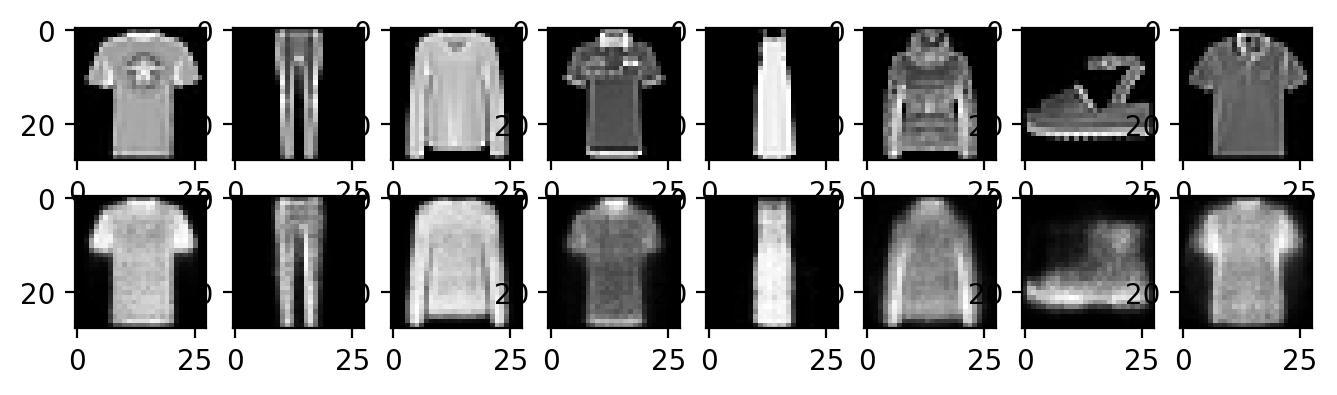

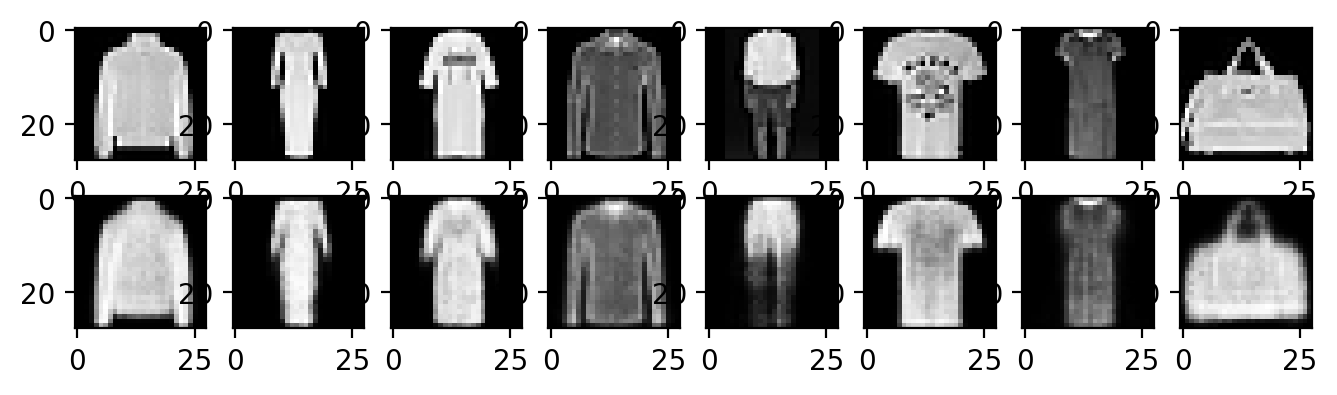

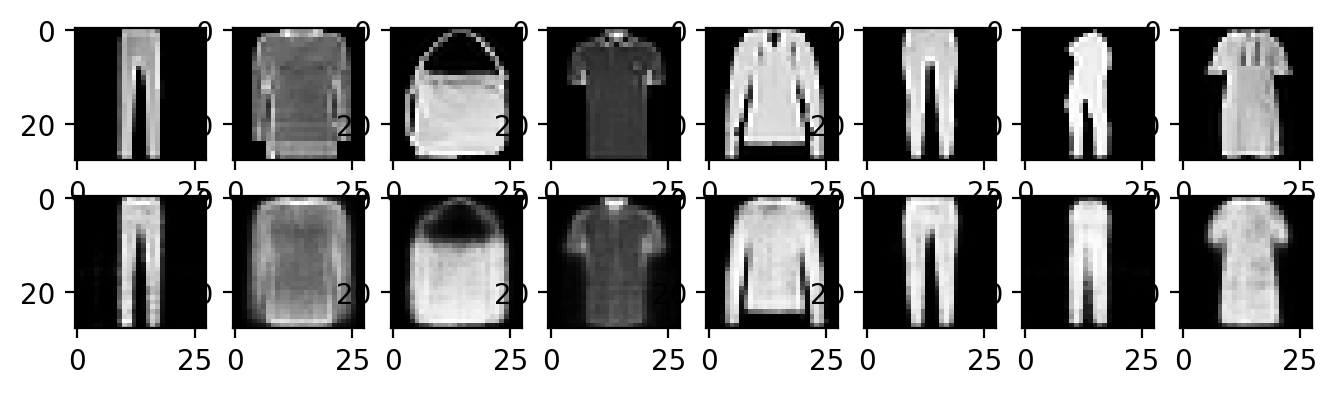

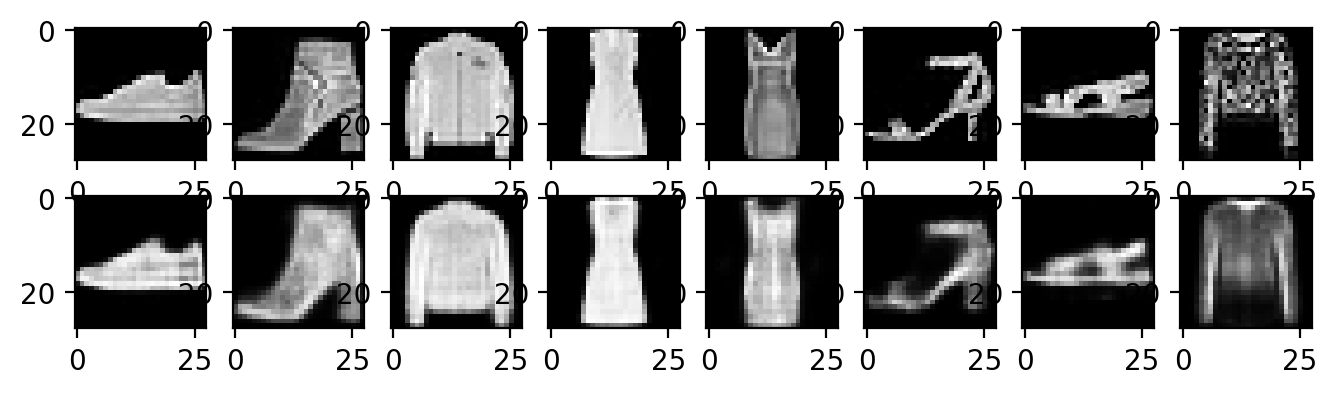

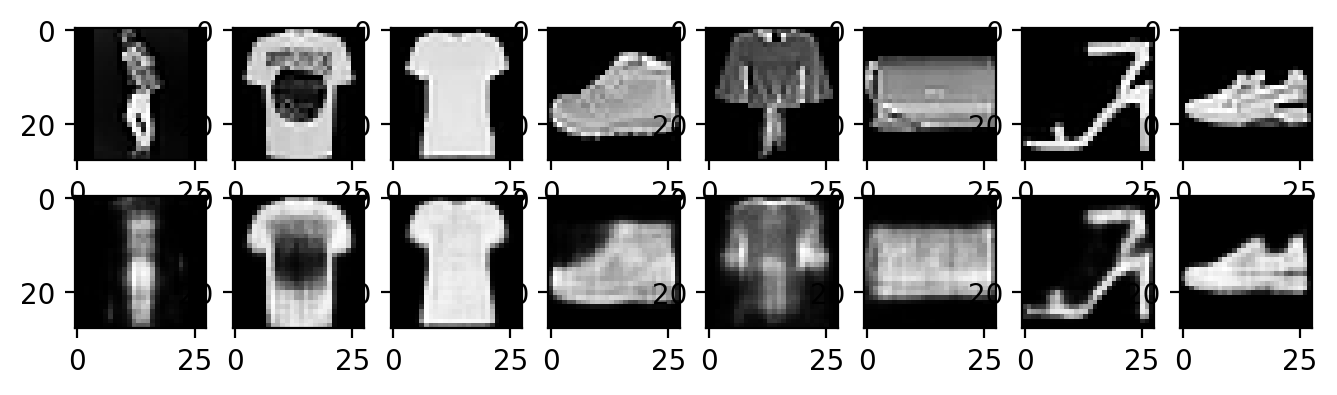

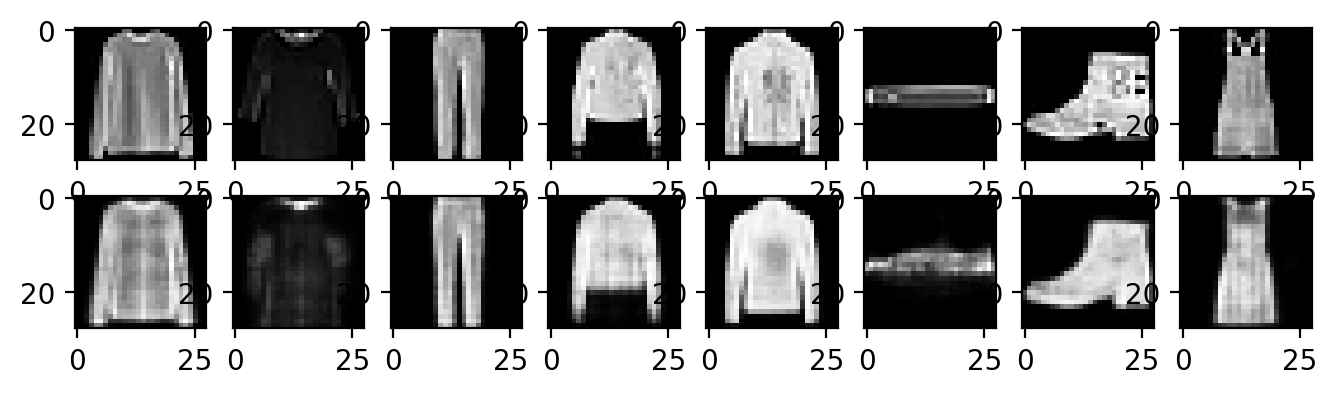

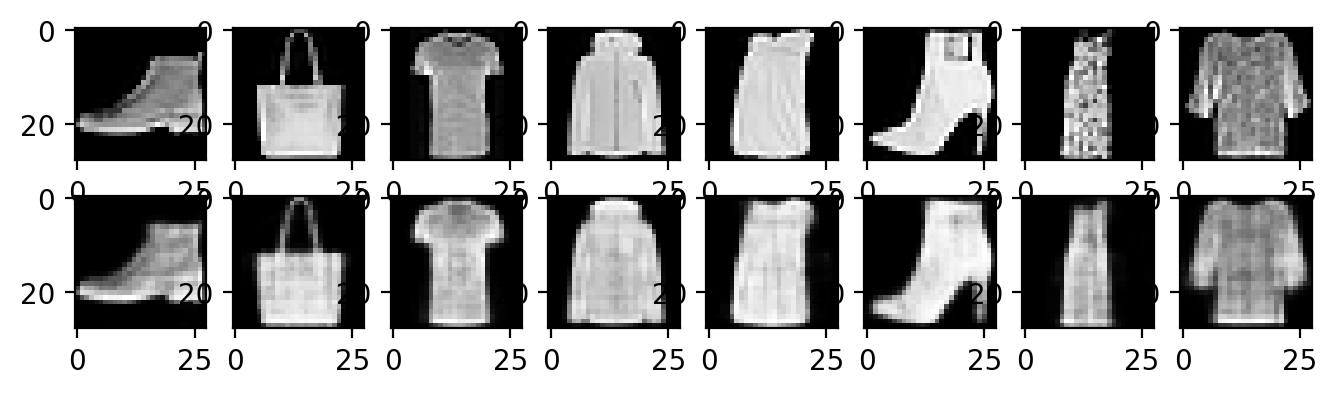

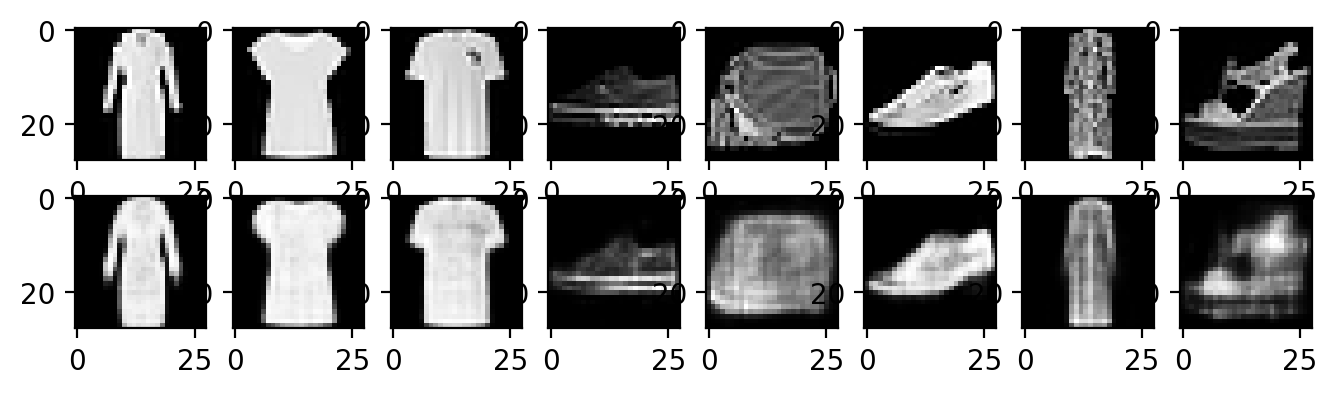

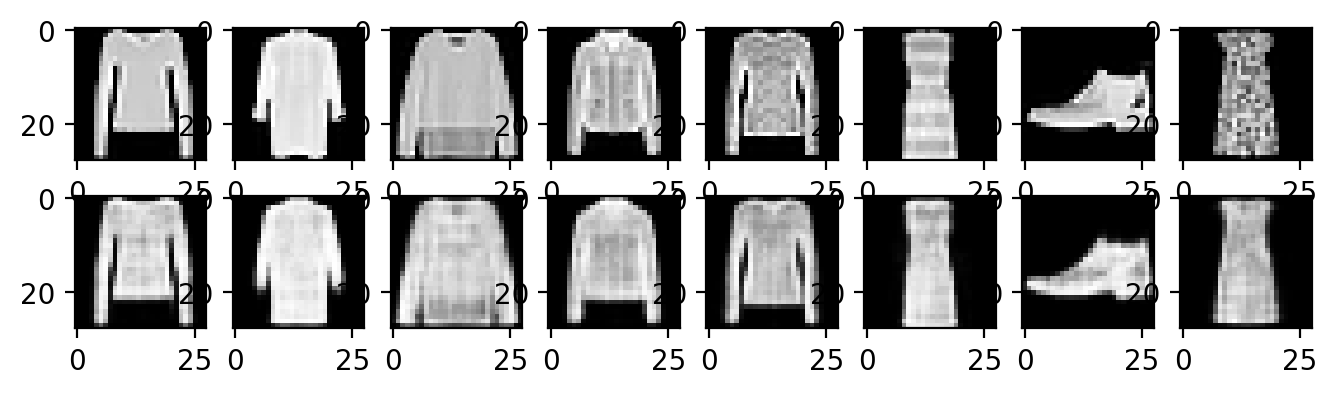

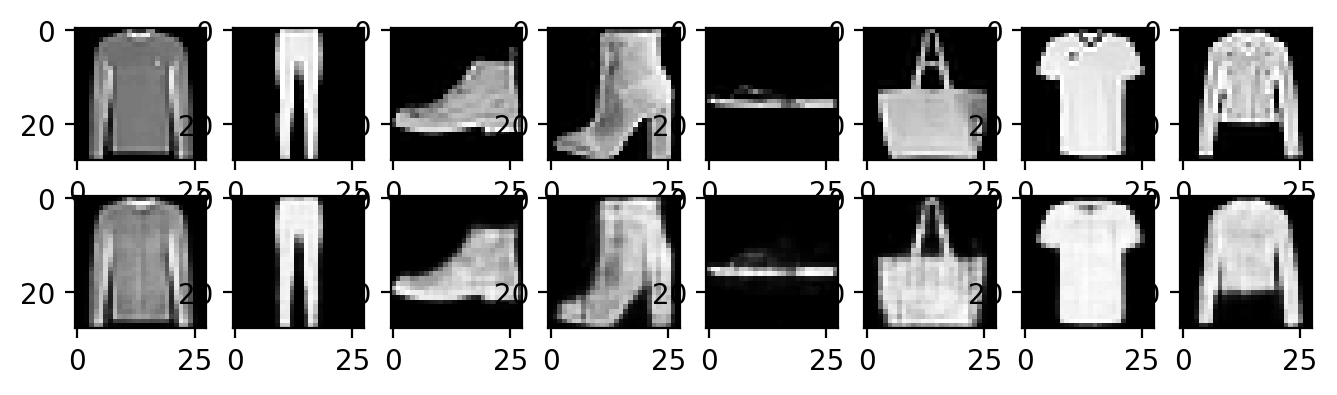

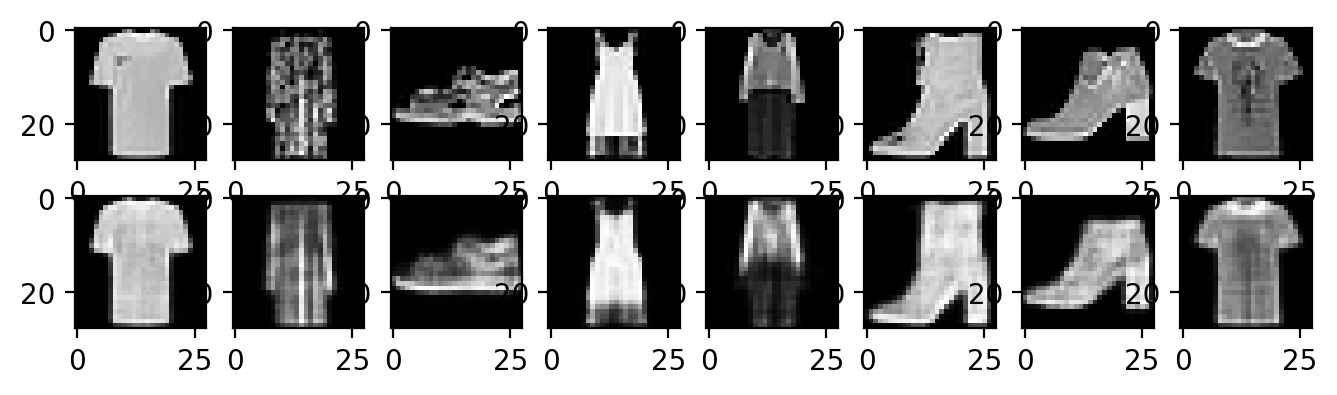

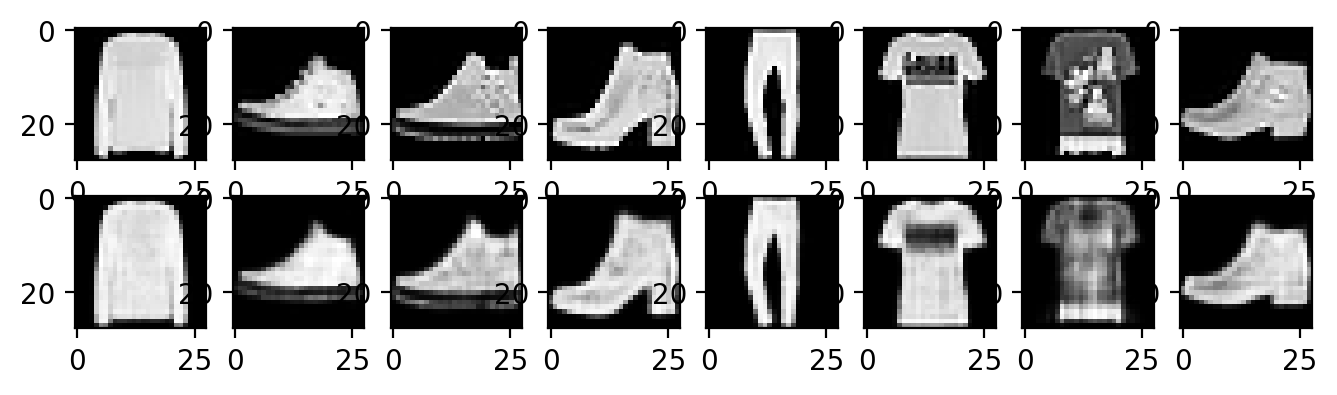

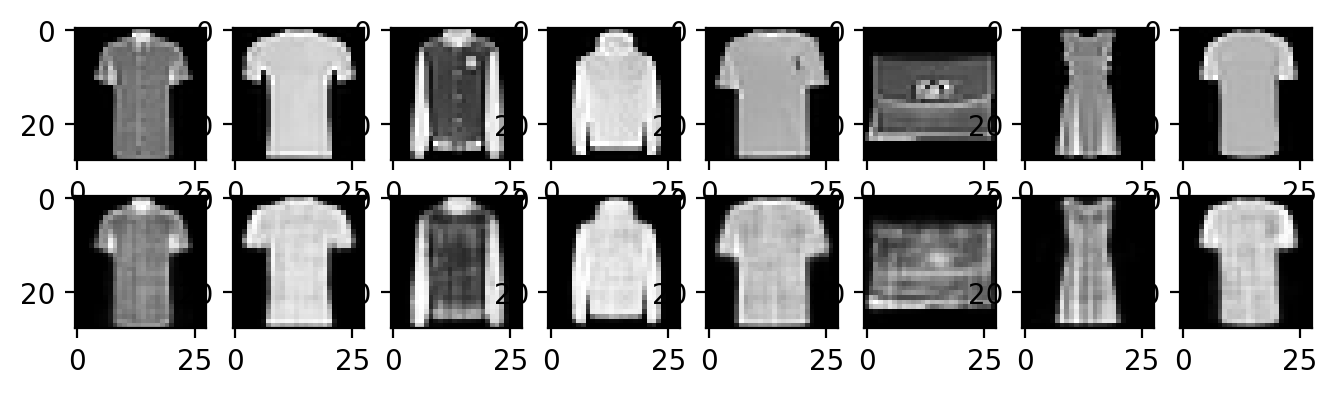

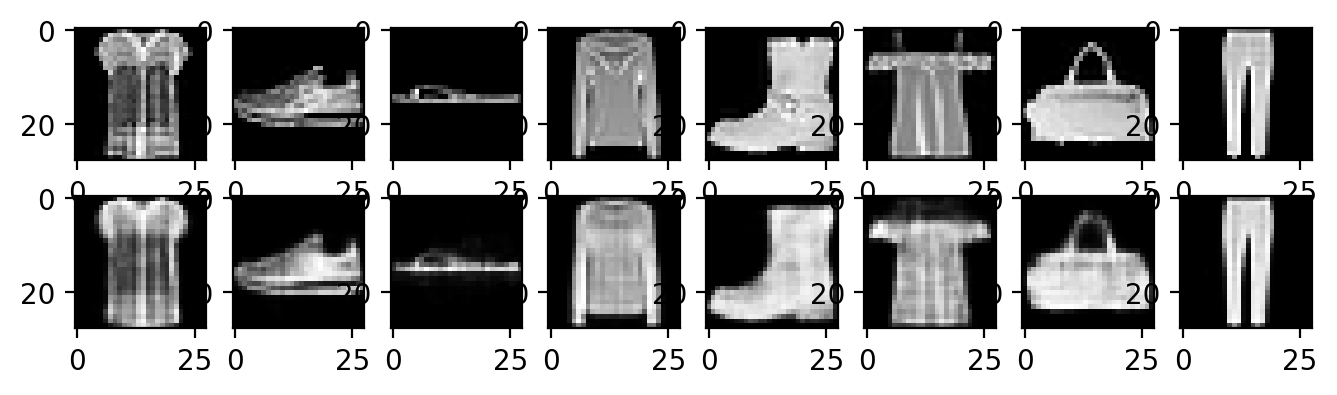

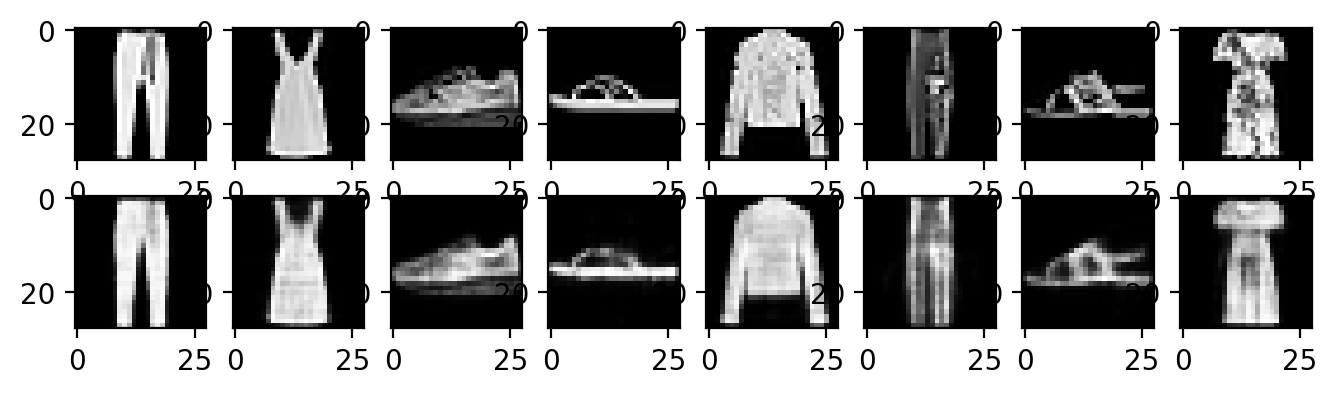

In [13]:
for k in range(0,epochs,2):
  plt.figure(figsize=(9,2))
  plt.gray()
  imgs = model.outputs[k][2].detach().numpy()
  recon = model.outputs[k][3].detach().numpy()
  for i, item in enumerate(imgs):
    if i >=9: break
    plt.subplot(2,9,i+1)
    item = item.reshape(-1,28,28)

    plt.imshow(item[0])
  for i, item in enumerate(recon):
    if i >=9: break
    plt.subplot(2,9,i+1+9)
    item = item.reshape(-1,28,28)

    plt.imshow(item[0])



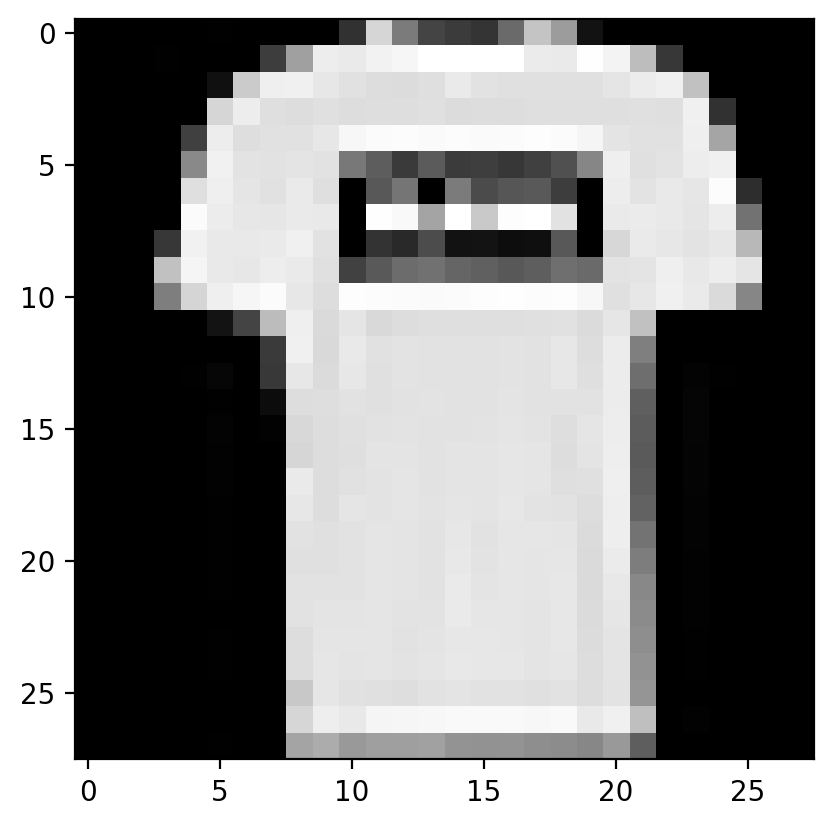

In [22]:
# Adding noise
def add_noise(img, variance):
    noise = np.random.normal(loc=0, scale=np.sqrt(variance), size=img.shape)
    return img + noise
img = train_set[INDEX].dataset.data[1,:,:]
noised_img = add_noise(img, 100)
plt.imshow(img.numpy().reshape([28,28]), cmap='Greys_r')

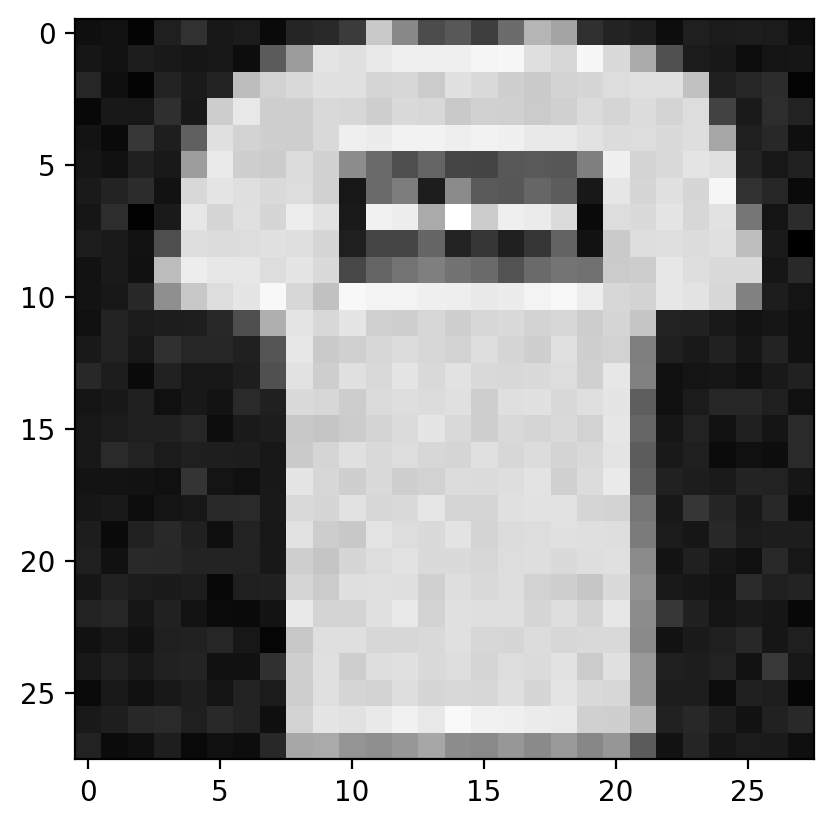

In [23]:
plt.imshow(noised_img.numpy().reshape([28,28]), cmap='Greys_r')

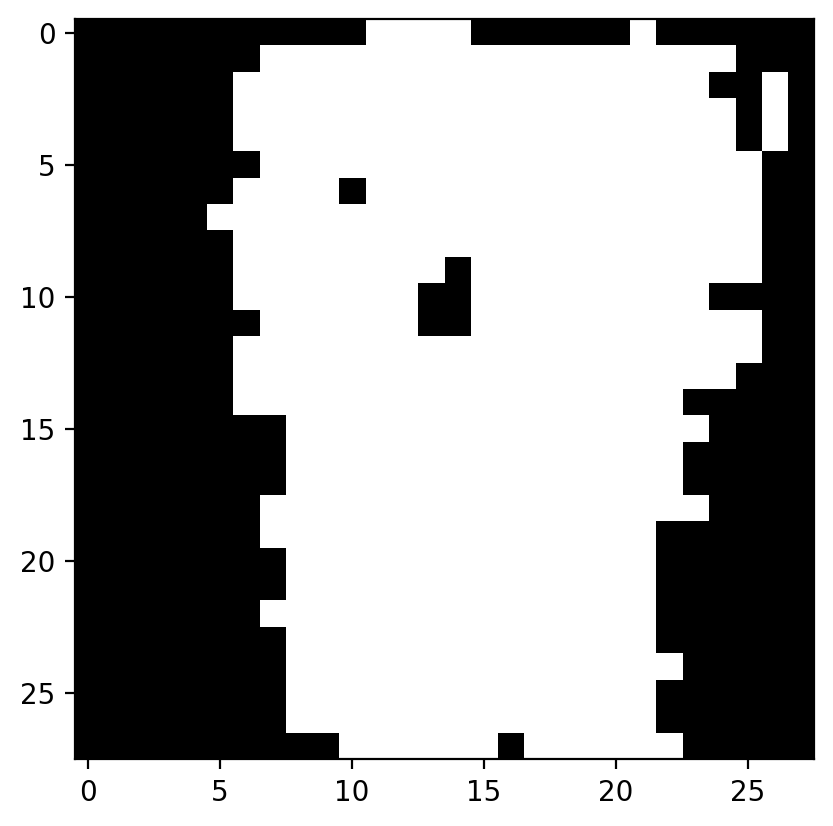

In [24]:
noised_img = noised_img.reshape(-1, 784)
reconstructed = models_autoencoder3[-1].forward(noised_img.float())
plt.imshow(reconstructed.detach().numpy().reshape([28,28]))

# 5 layers at both encoder/decoder:

In [11]:
class autoencoder5(nn.Module):
    def __init__(self,projected_dimension):
        super().__init__()
        self.projected_dimension = projected_dimension
        self.criterion = nn.MSELoss()
        self.learning_rate = 0.001

        if INDEX == 0:  # MNIST
            self.name_train = f"5_layer_with_PSNR_train_MNIST_{self.projected_dimension}"
            self.name_test = f"5_layer_with_PSNR_test_MNIST_{self.projected_dimension}"
            self.dataset = "MNIST"

        elif INDEX == 1:  # FMNIST
            self.name_train = f"5_layer_with_PSNR_train_FMNIST_{self.projected_dimension}"
            self.name_test = f"5_layer_with_PSNR_test_FMNIST_{self.projected_dimension}"
            self.dataset = "FMNIST"

        else:
            raise ValueError("Inside autoencoder5, INDEX should be either 0 or 1.")


        self.project = "project_1"
        self.architecture = "linear_autoencoder"
        self.input_image_size = 784
        self.outputs = []
        self.loss_during_training = []
        self.valid_loss_during_training = []

        # Building an linear encoder with Linear
        # layer followed by Relu activation function
        # 784 -> projected dimension
        self.encoder = nn.Sequential(
            nn.Linear(784, 550),
            nn.ReLU(),
            #nn.Dropout(p=0.2),
            nn.Linear(550, 400),
            nn.ReLU(),
            #nn.Dropout(p=0.2),
            nn.Linear(400, 300),
            nn.ReLU(),
            #nn.Dropout(p=0.2),
            nn.Linear(300,200),
            nn.ReLU(),
            #nn.Dropout(p=0.2),
            nn.Linear(200,projected_dimension)
        )

        # Building an linear decoder with Linear
        # layer followed by Relu activation function
        # The Sigmoid activation function
        # outputs the value between 0 and 1
        # projected dimension -> 784
        self.decoder = nn.Sequential(
            nn.Linear(projected_dimension, 200),
            nn.ReLU(),
            #nn.Dropout(p=0.2),
            nn.Linear(200, 300),
            nn.ReLU(),
            #nn.Dropout(p=0.2),
            nn.Linear(300, 400),
            nn.ReLU(),
            #nn.Dropout(p=0.2),
            nn.Linear(400,550),
            nn.ReLU(),
            #nn.Dropout(p=0.2),
            nn.Linear(550,784),
            nn.Tanh()
        )

        self.optimizer = optim.Adam(self.parameters(), self.learning_rate)

    def forward(self, image):
        encoded = self.encoder(image)
        decoded = self.decoder(encoded)
        return decoded

    def psnr(self, img1, img2):  #  Peak signal-to-noise ratio (PSNR)
        mse_criterio = nn.MSELoss()
        mse = mse_criterio(img1, img2)
        max_pixel = 1.0
        psnr = 20 * torch.log10(max_pixel / torch.sqrt(mse))
        return psnr

    def do_training(self, epochs, train_data, valid_data):
        self.train()


        wandb.init(  # Esto es para que se guarde en la plataforma de wandb y nos evitamos tener que hacerlo manualmente
            # Set the project where this run will be logged
            project=self.project,
            # We pass a run name (otherwise it’ll be randomly assigned, like sunshine-lollypop-10)
            name=self.name_train,
            # Track hyperparameters and run metadata
            config={
                "learning_rate": self.learning_rate,
                "architecture": self.architecture,
                "dataset": self.dataset,
                "epochs": epochs,
            },
        )

        # Aqui es donde empieza realmente el entrenamiento
        for epoch in range(epochs):
            running_loss = 0.
            for img, _ in train_data:
                self.optimizer.zero_grad()
                img = img.reshape(-1, self.input_image_size)
                reconstructed = model.forward(img)
                loss_train = self.criterion(reconstructed, img)

                running_loss += loss_train.item()
                loss_train.backward()
                self.optimizer.step()

            self.loss_during_training.append(running_loss/len(train_data))

            with torch.no_grad():

                # set model to evaluation mode
                self.eval()

                running_loss = 0.

                for images,_ in valid_data:

                    images = images.reshape(-1, self.input_image_size)

                    out = self.forward(images)

                    loss_valid = self.criterion(out,images)

                    running_loss += loss_valid.item()
                self.valid_loss_during_training.append(running_loss/len(valid_data))

            # set model back to train mode
            self.train()

            print("Epoch: ", epoch + 1, "Loss train: ", self.loss_during_training[-1], ", Loss valid: ", self.valid_loss_during_training[-1])
            wandb.log({"projected dimension": projected_dimensions[run], "Loss train": self.loss_during_training[-1], "Loss valid": self.valid_loss_during_training[-1]})
            self.outputs.append((projected_dimensions[run], epoch, img, reconstructed))

        wandb.finish()

    def eval_performance(self,data_test):

      performance = 0

      # Turn off gradients for validation, saves memory and computations
      with torch.no_grad():

          # set model to evaluation mode
          self.eval()

          for images,_ in data_test:

              img = images.view(-1, self.input_image_size)
              reconstructed = self.forward(img)
              performance = self.psnr(reconstructed, img)


          return performance

In [18]:
projected_dimensions = [15, 30, 50, 100]
epochs = 30
models_autoencoder5 = []
for run in range(len(projected_dimensions)):
    model = autoencoder5(projected_dimensions[run])  # To initialize the model with the projected dimension
    model.do_training(epochs,train_set[INDEX], valid_set[INDEX])
    models_autoencoder5.append(model)

Epoch:  1 Loss train:  0.20077844192697245 , Loss valid:  0.1356616902858653
Epoch:  2 Loss train:  0.1157607698220421 , Loss valid:  0.1080688124641459
Epoch:  3 Loss train:  0.09600080065005882 , Loss valid:  0.09233898647288058
Epoch:  4 Loss train:  0.08391867596021091 , Loss valid:  0.08282232848887748
Epoch:  5 Loss train:  0.07606320489536632 , Loss valid:  0.07562803278895135
Epoch:  6 Loss train:  0.07089229322842915 , Loss valid:  0.07257152074512015
Epoch:  7 Loss train:  0.06700879758202725 , Loss valid:  0.06939082621259893
Epoch:  8 Loss train:  0.06354055282215333 , Loss valid:  0.06636984101001253
Epoch:  9 Loss train:  0.06118786719691178 , Loss valid:  0.06494162865775696
Epoch:  10 Loss train:  0.05900059616066177 , Loss valid:  0.06250537735350589
Epoch:  11 Loss train:  0.057015409529082135 , Loss valid:  0.061052669600603425
Epoch:  12 Loss train:  0.05568939947459677 , Loss valid:  0.0606036828236377
Epoch:  13 Loss train:  0.0543986147491854 , Loss valid:  0.059

Loss train,█▄▃▃▃▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Loss valid,█▆▅▄▃▃▃▂▂▂▂▂▂▂▂▂▂▂▁▂▁▁▁▁▁▁▁▁▁▁
projected dimension,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Loss train,0.04056
Loss valid,0.04801
projected dimension,15


Epoch:  1 Loss train:  0.19922852268527177 , Loss valid:  0.13369552705516208
Epoch:  2 Loss train:  0.12055318511556834 , Loss valid:  0.11718746357141657
Epoch:  3 Loss train:  0.10608258336486126 , Loss valid:  0.10046215634396735
Epoch:  4 Loss train:  0.09368769745130769 , Loss valid:  0.09404523046092784
Epoch:  5 Loss train:  0.08608981446278366 , Loss valid:  0.08715246072474947
Epoch:  6 Loss train:  0.08090042814993384 , Loss valid:  0.08268086456872047
Epoch:  7 Loss train:  0.07597024341389029 , Loss valid:  0.07805770337581634
Epoch:  8 Loss train:  0.07159080520399254 , Loss valid:  0.07399376505549918
Epoch:  9 Loss train:  0.06714461791456085 , Loss valid:  0.07006471077812479
Epoch:  10 Loss train:  0.06345001743069258 , Loss valid:  0.06616939602697149
Epoch:  11 Loss train:  0.060877952269617126 , Loss valid:  0.06278120577335358
Epoch:  12 Loss train:  0.05824704375118017 , Loss valid:  0.06264892489986217
Epoch:  13 Loss train:  0.05651078119461255 , Loss valid:  0

Loss train,█▅▄▃▃▃▃▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Loss valid,█▇▅▅▄▄▃▃▃▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁
projected dimension,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Loss train,0.04016
Loss valid,0.0481
projected dimension,30


Epoch:  1 Loss train:  0.19839657706589522 , Loss valid:  0.14230850874743564
Epoch:  2 Loss train:  0.11739652228160677 , Loss valid:  0.10555442197525755
Epoch:  3 Loss train:  0.09688997444358062 , Loss valid:  0.09422711783901173
Epoch:  4 Loss train:  0.08791299931577999 , Loss valid:  0.0875931127908382
Epoch:  5 Loss train:  0.0825973098822446 , Loss valid:  0.08333970793384186
Epoch:  6 Loss train:  0.07873110357798975 , Loss valid:  0.08025642119823619
Epoch:  7 Loss train:  0.07448138066948476 , Loss valid:  0.07709320650455799
Epoch:  8 Loss train:  0.07066606568299573 , Loss valid:  0.07298197506907138
Epoch:  9 Loss train:  0.06770726017632776 , Loss valid:  0.07227062221537245
Epoch:  10 Loss train:  0.0656058314806697 , Loss valid:  0.071539533978447
Epoch:  11 Loss train:  0.06342142094349996 , Loss valid:  0.06850719347279123
Epoch:  12 Loss train:  0.061679556135045874 , Loss valid:  0.06564865787612631
Epoch:  13 Loss train:  0.060005911631213334 , Loss valid:  0.064

Loss train,█▄▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁
Loss valid,█▅▄▄▄▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁
projected dimension,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Loss train,0.04226
Loss valid,0.04954
projected dimension,50


Epoch:  1 Loss train:  0.19779753862795504 , Loss valid:  0.13620411839256896
Epoch:  2 Loss train:  0.11310057162137871 , Loss valid:  0.10450149371902993
Epoch:  3 Loss train:  0.09490237774496729 , Loss valid:  0.09156296246863425
Epoch:  4 Loss train:  0.08635214165869085 , Loss valid:  0.08632210692826738
Epoch:  5 Loss train:  0.08191924073352394 , Loss valid:  0.0822024996927444
Epoch:  6 Loss train:  0.07818649153606119 , Loss valid:  0.0813122403748492
Epoch:  7 Loss train:  0.07611859231044284 , Loss valid:  0.07836050096344441
Epoch:  8 Loss train:  0.07372488873608579 , Loss valid:  0.07678172710411092
Epoch:  9 Loss train:  0.07119166299658404 , Loss valid:  0.07356274898381944
Epoch:  10 Loss train:  0.06807761462087827 , Loss valid:  0.07052806734721712
Epoch:  11 Loss train:  0.06443495191210373 , Loss valid:  0.06741605884534248
Epoch:  12 Loss train:  0.0615486670920456 , Loss valid:  0.0676705056841069
Epoch:  13 Loss train:  0.05943756963824853 , Loss valid:  0.0625

Loss train,█▄▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁
Loss valid,█▅▄▄▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▁▂▁▁▁▁▁▁▁
projected dimension,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Loss train,0.04142
Loss valid,0.04831
projected dimension,100


# Save the models

In [19]:
if INDEX == 0:  # MNIST
  for i in range(len(models_autoencoder3)):
    torch.save(models_autoencoder3[i].state_dict(), f'model_autoencoder3_MNIST_{projected_dimensions[i]}.pth')
    torch.save(models_autoencoder5[i].state_dict(), f'model_autoencoder5_MNIST_{projected_dimensions[i]}.pth')
elif INDEX == 1:  # FMNIST
  for i in range(len(models_autoencoder3)):
    torch.save(models_autoencoder3[i].state_dict(), f'model_autoencoder3_FMNIST_{projected_dimensions[i]}.pth')
    torch.save(models_autoencoder5[i].state_dict(), f'model_autoencoder5_FMNIST_{projected_dimensions[i]}.pth')

else:
        raise ValueError("While saving the models, INDEX should be either 0 or 1.")

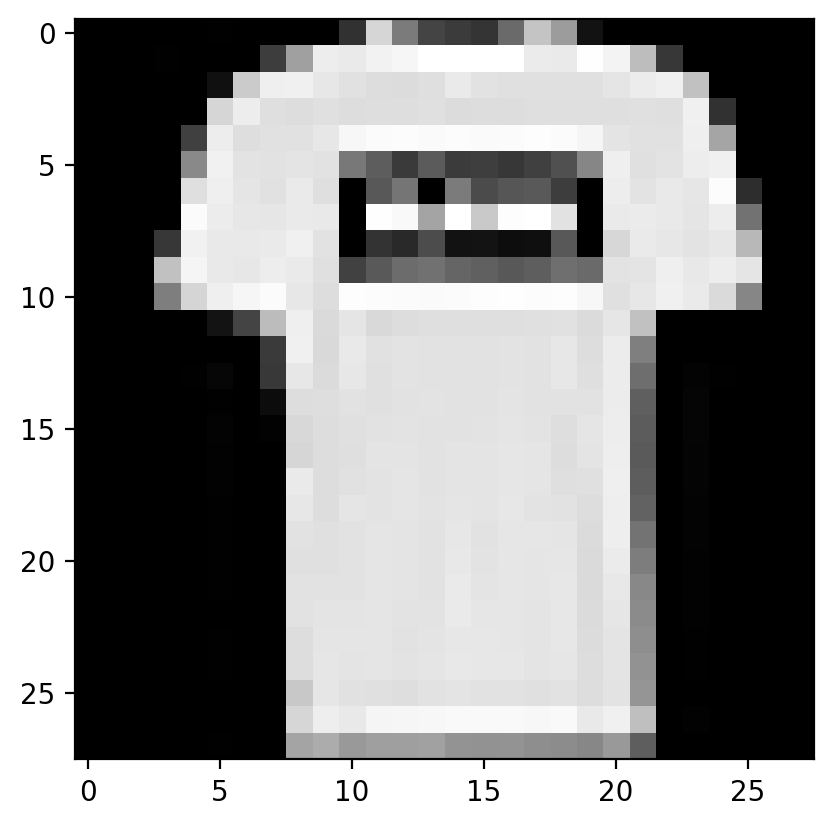

In [26]:
img = train_set[INDEX].dataset.data[1,:,:]
noised_img = add_noise(img, 100)
plt.imshow(img.numpy().reshape([28,28]), cmap='Greys_r')


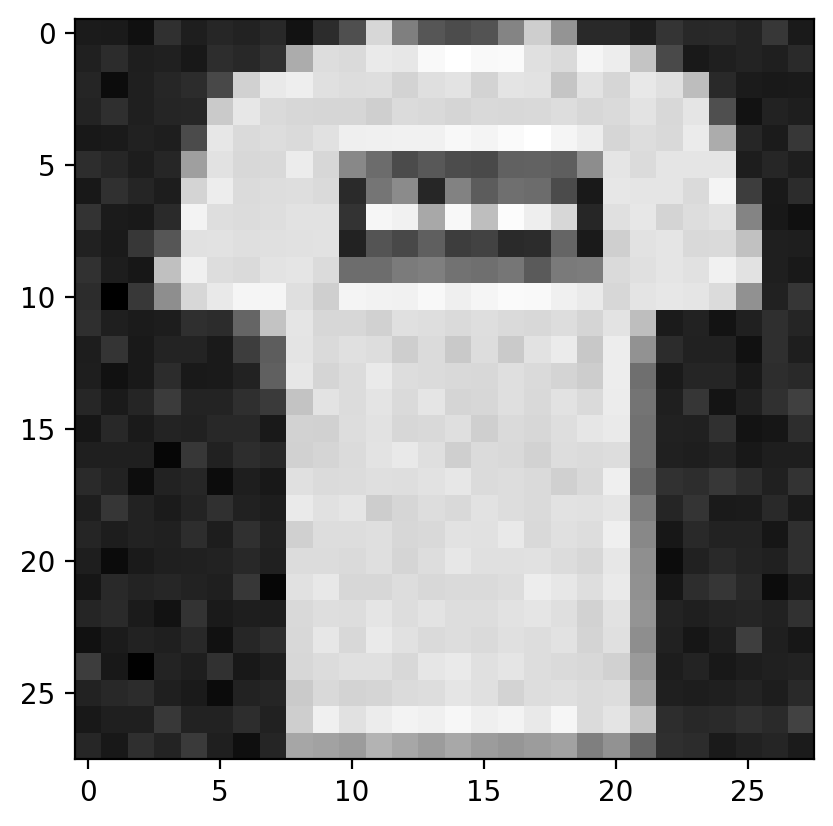

In [27]:
plt.imshow(noised_img.numpy().reshape([28,28]), cmap='Greys_r')

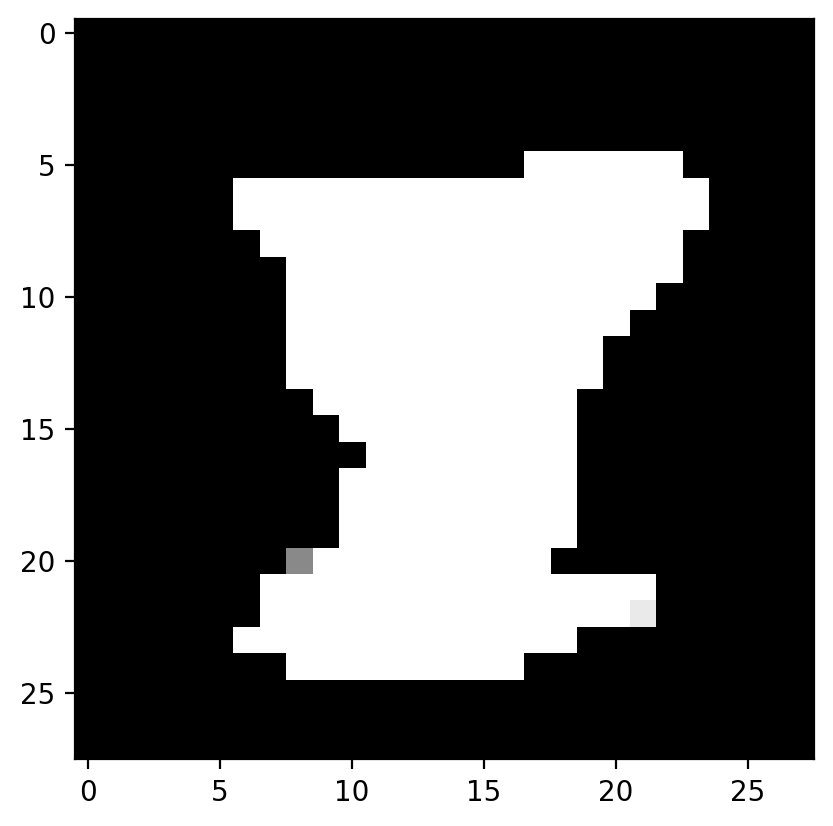

In [28]:
noised_img5 = noised_img.reshape(-1, 784)
reconstructed5 = models_autoencoder5[-1].forward(noised_img5.float())
plt.imshow(reconstructed5.detach().numpy().reshape([28,28]))

In [12]:
import torch
projected_dimensions = [15, 30, 50, 100] # This are the dimensions we are going to project the data into
models_autoencoder3 = []
models_autoencoder5 = []

if INDEX == 0:  # MNIST
  dataset0 = "MNIST"
else:
  dataset0 = "FMNIST"

for i in range(4):
    state_dict = torch.load(f'model_autoencoder3_{dataset0}_{projected_dimensions[i]}.pth')
    model_3 = autoencoder3(projected_dimensions[i])
    model_3.load_state_dict(state_dict)
    models_autoencoder3.append(model_3)

    state_dict = torch.load(f'model_autoencoder5_{dataset0}_{projected_dimensions[i]}.pth')
    model_5 = autoencoder5(projected_dimensions[i])
    model_5.load_state_dict(state_dict)
    models_autoencoder5.append(model_5)



In [13]:
def evaluate_model(models, train, valid, test):
    for n_layers in range(len(models)):
        for i, model in enumerate(models[n_layers]):
            n_lay = 3 if n_layers == 0 else 5
            print(f"Autoenc{n_lay}, train-{projected_dimensions[i]}. Projections:", model.eval_performance(train))
            print(f"Autoenc{n_lay}, val-{projected_dimensions[i]}. Projections:", model.eval_performance(valid))
            print(f"Autoenc{n_lay}, test-{projected_dimensions[i]}. Projections:", model.eval_performance(test), "\n")

In [14]:
models = [models_autoencoder3, models_autoencoder5]
evaluate_model(models, train_MNIST, valid_MNIST, test_MNIST)

Autoenc3, train-15. Projections: tensor(7.0459)
Autoenc3, val-15. Projections: tensor(7.1948)
Autoenc3, test-15. Projections: tensor(7.2008) 

Autoenc3, train-30. Projections: tensor(8.4783)
Autoenc3, val-30. Projections: tensor(8.8041)
Autoenc3, test-30. Projections: tensor(7.9905) 

Autoenc3, train-50. Projections: tensor(8.8348)
Autoenc3, val-50. Projections: tensor(9.6668)
Autoenc3, test-50. Projections: tensor(8.6534) 

Autoenc3, train-100. Projections: tensor(10.2536)
Autoenc3, val-100. Projections: tensor(10.4778)
Autoenc3, test-100. Projections: tensor(10.5159) 

Autoenc5, train-15. Projections: tensor(13.7838)
Autoenc5, val-15. Projections: tensor(13.4368)
Autoenc5, test-15. Projections: tensor(12.2678) 

Autoenc5, train-30. Projections: tensor(12.4968)
Autoenc5, val-30. Projections: tensor(13.9470)
Autoenc5, test-30. Projections: tensor(12.8224) 

Autoenc5, train-50. Projections: tensor(17.7074)
Autoenc5, val-50. Projections: tensor(12.4764)
Autoenc5, test-50. Projections: te

## Training the models with early stopping and dropout